<a href="https://colab.research.google.com/github/omanofx/portfolio/blob/main/data_wrangling/data_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Author: Omar Fernández

# The Project

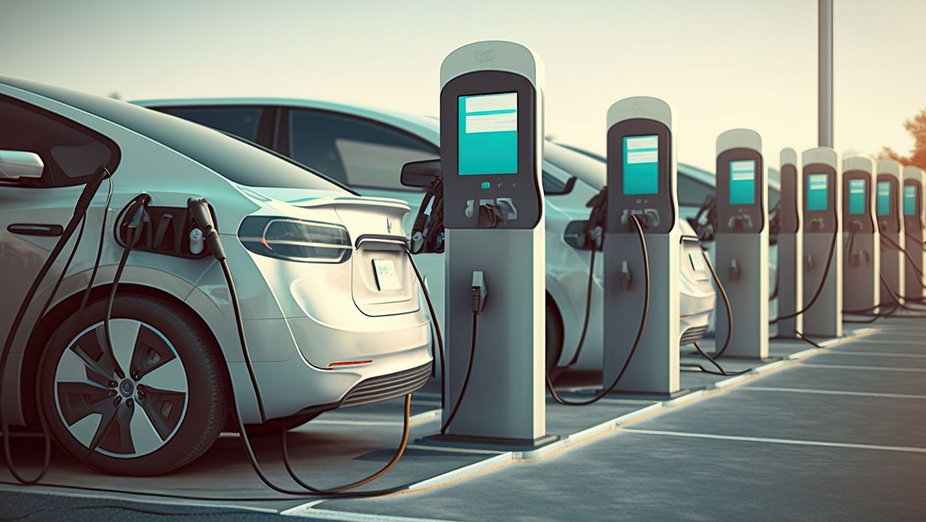

# Table of Contents

1. Executive Summary
1. Introduction
  1. Objective of the project
  1. Stakeholders
  1. Project Scope
  1. Assumptions and limitations
  1. Analysis to be performed
  1. Solution
1. Analytical context
  1. Requirements
  1. The Dataset
  1. Data set structure
  1. Data dimensions
  1. Libraries used
  1. Setting
  1. Functions
1. Data acquisition
  1. Github
  1. External data (API)
  1. Backup
1. Data wrangling
  1. Main data set
  1. Target variable
  1. Feature Reduction
  1. Duplicate values
  1. NaN values
  1. Wrong values
  1. Data type transformation
  1. Categorical variable labeling
  1. Attribute engineering
  1. Outliers
  1. z-score method
  1. IQR method
  1. Secondary data set (optional)
  1. Save files
1. Exploratory Data Analysis (EDA)
  1. EDA Conclusions
1. Feature Selection
  1. Correlation matrix
  1. Stepwise
1. Model training
  1. Split the dataframe
1. Massive model training
  1. Models: Configuration
  1. Comparison
  1. ROC Raven
  1. Bias and Variance
1. Final project results
1. Conclusions and final recommendations
1. References
1. Change log

# Analytical context

## The dataset (update 2024)

This spreadsheet shows historical alternative fueling station counts by state on an annual basis since December 2007. This data is based on the number of public and private (non-residential) stations in the Alternative Fuels Data Center (AFDC) Alternative Fueling Station Locator (https://afdc.energy.gov/stations/) near the end of December each year. You can see total fuel type counts in the "Total" row at the bottom of each tab.

Note that changes in total counts represent both stations that opened and went out of service. For example, if the number of stations increased from 200 to 210 in one year, it could have been that 15 stations opened and 5 stations went out of service.

Please note the following regarding counts for the electric vehicle (EV) charging station data:
 - **Starting in 2011**, EV charging was counted by the outlet rather than by the geographical location.
 - **Beginning in 2014**, the historical data for EV charging includes both the number of EV charging station locations and the number of outlets at each location.  
 - **Starting in 2020**, EV charging data is provided by charger level.


Please note the following regarding counts for propane station data:
 - Starting in 2020, propane station data is broken down by primary or secondary designations.


* More data sets: https://afdc.energy.gov/data_download

* Historical data set (since 2014): https://afdc.energy.gov/stations/states?count=total&include_temporarily_unavailable=false&date=

* Using API to get the data: https://developer.nrel.gov/docs/transportation/alt-fuel-stations-v1/

https://www.visualcapitalist.com/interactive-ev-charging-stations-across-the-u-s-mapped/

## Libraries used

In [1]:
# Data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Data manipulation and analysis
import numpy as np
import pandas as pd

# Other
import datetime
from datetime import datetime, timedelta

# Set the local time zone
import pytz

# Additional settings
%matplotlib inline

# Import warnings module
import warnings
warnings.filterwarnings('ignore')

# File import
import requests
from openpyxl import load_workbook
from io import BytesIO

## Setting

In [2]:
# Set the local time zone
time_zone = pytz.timezone('America/Argentina/Buenos_Aires')
formato_fecha_hora = '%Y-%m-%d %H:%M:%S'

# Record separator
my_separator = "|"

## Functions

In [3]:
def split_column_and_concat(df: pd.DataFrame, column_name: str, separator='|', new_column_names=None, ):
    """
    Split a column of a DataFrame into new columns using a separator
     and concatenate these new columns to the original DataFrame.

     Parameters:
     df (pandas.DataFrame): Original DataFrame.
     column_name (str): Name of the column to be split.
     separator (str): Separator used to divide the column values.
     new_column_names (list): Optional list of names for the new columns resulting from the split.
                              If not provided, names will be automatically generated.

     Returns:
     pandas.DataFrame: DataFrame with the new columns resulting from the division concatenated to the original.
    """
    if df[column_name].dtype == 'float64':
      print(f"There are no pipies characters in the analyzed column.", column_name)
      return

    # Split column values into new columns
    new_columns = df[column_name].str.split(separator, expand=True)

    # Generate column names if not provided
    if new_column_names is None:
        new_column_names = [f"{column_name}_{i+1}" for i in range(new_columns.shape[1])]

    # Assign names to new columns
    new_columns.columns = new_column_names

    # Concatenate the new columns to the original DataFrame
    df = pd.concat([df, new_columns], axis=1)

    return df

In [4]:
def procesar_hoja(df_temp: pd.DataFrame):
  try:
      #Delete 'Total' and subsequent row
      indice_maximo = len(df_temp) -1 # Starts at 0
      ix_columna_total = df_temp[df_temp['State'] == 'Total'].index[0]

      if indice_maximo == ix_columna_total:
        df_temp.drop(index = ix_columna_total, inplace=True)

      else:
        # There are records after 'Total'
        df_temp.drop(index=[ix_columna_total,
                            ix_columna_total +1], inplace=True)

      # deletes records when 'State' and 'Total' columns are NaN
      df_temp = df_temp.dropna(subset=['State','Electric', 'Total'],how='all')

      # Delete records with all NaN columns
      df_temp = df_temp.dropna(how='all')

      # Add a new 'Year' column with the sheet name
      df_temp['Year'] = int(hoja)

      # Replaces characters
      df_temp = df_temp.replace('/', '|', regex=True)
      df_temp = df_temp.replace(',', '', regex=True)

      return df_temp

  except Exception as e:
        # In case of error, print the error and return None
        print("Error processing the excel sheet:", str(e))
        return None

In [5]:
def fecha_hora_local(local_timezone: pytz.timezone = pytz.timezone('America/Argentina/Buenos_Aires')):
    '''
    This function displays the local date and time each time it is invoked.
     :param local_timezone: The desired local time zone (default 'America/Argentina/Buenos_Aires').
     :return: The local date and time in the specified format.
    '''
    try:
        # Gets the current local time in UTC
        utc_now = datetime.utcnow()

        # Convert current time to local time
        local_time = utc_now.replace(tzinfo=pytz.utc).astimezone(local_timezone)

        # Output format for local date and time
        formato_fecha_hora = "%Y-%m-%d %H:%M:%S"

        # Returns the formatted local date and time
        return local_time.strftime(formato_fecha_hora)

    except Exception as e:
        # In case of error, print the error and return None
        print("Error getting local date and time:", str(e))
        return None

In [6]:
def grabar_csv(nombre_archivo: str, df: pd.DataFrame):
    '''
    Physically stores the data obtained in a CSV file.
     :param filename: The base name of the CSV file.
     :param df: The DataFrame that you want to save in the CSV file.
     '''
    try:
        # Gets the current date and time to add to the file name
        fecha_y_hora_actual = fecha_hora_local(time_zone)

        # Specifies the path and name of the CSV file
        ruta_archivo_csv = f"{nombre_archivo}_{fecha_y_hora_actual}.csv"

        # Save the DataFrame to a CSV file without including the index
        df.to_csv(ruta_archivo_csv, index = False)

        # Prints the save date and time and file path
        print("Date and Time:", fecha_y_hora_actual)
        print(f"Data has been saved in CSV file: {ruta_archivo_csv}")

    except Exception as error:
        #Handles any errors that may occur during the save process
        print(f"An error occurred while saving data to CSV file: {error}")

In [7]:
def tiene_espacios_en_blanco(columna: str) -> bool:
    '''
    Verifica si una columna contiene espacios en blanco.
    :param columna: La columna a ser verificada (str).
    :return: True si la columna contiene al menos un espacio en blanco, False de lo contrario.
    '''
    try:
        # Utiliza una expresión generadora y la función any para verificar si
        # alguno de los caracteres es un espacio en blanco
        return any(caracter.isspace() for caracter in columna)

    except Exception as e:
        # En caso de error, imprime el error y retorna False
        print("Error al verificar espacios en blanco en la columna:", str(e))
        return False

In [8]:
def analizar_dataframe(df1: pd.DataFrame, porcentaje_tolerancia: float):
    '''
    ## Esta función se utiliza para comprobar la consistencia de los datos de un DataFrame
    ### evita invocar a .info(), .isnull()
    #### Porcentaje de tolerancia: valor porcentual que se tolera para los valores nulos de
    #### cada caracteristica del DataFrame. Si el valor se encuentra por sobre la tolerancia,
    #### se indica como 'BORRAR' la caracteristica.
    #### Version 2.0
    '''
    # Validar que porcentaje_tolerancia esté entre 0 y 100
    if not (0 <= porcentaje_tolerancia <= 100):
        print("Error: El porcentaje de tolerancia debe estar entre 0 y 100.")
        return

    porcentaje_perdidos = df1.isnull().sum() * 100 / len(df1)
    total_nulos = df1.isnull().sum()
    tipo_dato = df1.dtypes
    valores_no_nulos_por_columna = df1.count()
    descripcion = df1.describe().transpose()
    es_categorica = [True if tipo == 'object' else False for tipo in tipo_dato]
    total_ceros_por_columna = [(columna, (df1[columna] == 0).sum()) for columna in df1.columns]

    resultado_analisis = pd.DataFrame({
        'Tipo de dato': tipo_dato,
        'Total No Nulos': valores_no_nulos_por_columna,
        'Total Nulos': total_nulos,
        '% Nulos': round(porcentaje_perdidos, 2),
        'Borrar?': np.where(porcentaje_perdidos > porcentaje_tolerancia, 'BORRAR', ''),
        'Total Ceros': [total for columna, total in total_ceros_por_columna],
        'Columna con Espacios': df1.columns.to_series().apply(lambda x: tiene_espacios_en_blanco(x))
    })

    # Agregar las columnas de la descripción al resultado_analisis
    resultado_analisis = pd.concat([resultado_analisis, round(descripcion, 2)], axis=1)

    estilo_resultado = (
        resultado_analisis.style
        .applymap(lambda x: 'background-color: green' if x == 'object' else '',
                  subset=['Tipo de dato'])
        .applymap(lambda x: 'background-color: red' if x > porcentaje_tolerancia else '',
                  subset=pd.IndexSlice[resultado_analisis[resultado_analisis['% Nulos'] > porcentaje_tolerancia].index, '% Nulos'])
        .background_gradient(cmap='Reds', subset=['% Nulos'])
        .applymap(lambda x: 'background-color: red' if x else '',
                  subset=pd.IndexSlice[resultado_analisis[resultado_analisis['Columna con Espacios']].index, 'Columna con Espacios'])
        .background_gradient(cmap='Reds', subset=['Columna con Espacios'])
    )

    return estilo_resultado

# Data acquisition

## Read the charging stations csv file

In [9]:
try:
    df_stations = pd.read_csv('https://raw.githubusercontent.com/omanofx/portfolio/main/data_wrangling/electric_and_alternative_fuel_charging_stations.csv', sep =",")
    print("CSV file has been uploaded successfully.")

except Exception as e:
    print("An error occurred while uploading the CSV file:", e)

print(fecha_hora_local())

CSV file has been uploaded successfully.
2024-04-24 11:53:49


## Read the historical excel file

In [10]:
# URL del archivo .xlsx en GitHub
url = 'https://github.com/omanofx/portfolio/raw/main/data_wrangling/historical-station-counts.xlsx'

try:
    # Create an empty DataFrame
    df_hojas = pd.DataFrame()

    # Specify the path of your Excel file
    archivo_excel = url

    # Read the Excel file
    excel_file = pd.ExcelFile(archivo_excel)

    # Gets the names of the sheets in the Excel file
    hojas = excel_file.sheet_names

    # Delete the first sheet
    hojas.remove("About the Data")

    print(f"Keep only the number sheets.\n", hojas)

except Exception as e:
    print("An error occurred while loading the excel file:", e)

Keep only the number sheets.
 ['2023', '2022', '2021', '2020', '2019', '2018', '2017', '2016', '2015', '2014', '2013', '2012', '2011', '2010', '2009', '2008', '2007']


## Process the historical excel file

In [11]:
# List to store the processed DFs
list_of_df = []

try:
    print(" --- Loop Start --- \n")
    for hoja in hojas:
        year_sheet = int(hoja)

        print("Processing the sheet: " + hoja, " - News found")
        print(50 * "-")

        # Read data from Excel file and store it in a new DataFrame
        df_hojas = pd.read_excel(archivo_excel, sheet_name= hoja,
                                 header= 0,
                                 comment= '(', skiprows = 3)

        # Assign the correct names to the DF columns
        if year_sheet in range(2007, 2014):
            df_hojas.columns = ['State', 'Biodiesel', 'CNG', 'E85', 'Electric',
                                'Hydrogen', 'LNG', 'Propane', 'Total']

            # Add a new column 'Renewable Diesel'
            df_hojas.insert(8, 'Renewable_Diesel', np.NaN)

            # Process excel sheet
            df_ok = procesar_hoja(df_hojas)

        elif year_sheet in range(2014,2099):
            df_hojas.columns = ['State', 'Biodiesel', 'CNG', 'E85', 'Electric',
                                'Hydrogen', 'LNG', 'Propane','Renewable_Diesel',
                                'Total']

            # Process excel sheet
            df_ok = procesar_hoja(df_hojas)

            # Process secondary columns
            df_ok = split_column_and_concat(df_ok, 'Propane',
                                            separator= my_separator,
                                            new_column_names=['Propane_Primary',
                                                                'Propane_Secondary',
                                                                'Propane_Total'])

            df_ok = split_column_and_concat(df_ok, 'Hydrogen',
                                            separator= my_separator,
                                            new_column_names=['Hydrogen_Retail',
                                                                'Hydrogen_Non_Retail',
                                                                'Hydrogen_Total'])

            #Take the even indices of df_ok['Electric'] and do a split with the separator
            split_columns = df_ok['Electric'].iloc[::2].str.split(my_separator,
                                                                  expand=True)

            # Assign names to the new columns
            split_columns.columns = ['Electric_stations', 'Electric_outlets']

            # concatenate df_ok with new_columns_par
            df_ok = pd.concat([df_ok, split_columns], axis=1)

            # Take the odd indices of df_ok['Electric'] and do a split with the separator
            split_columns = df_ok['Electric'].iloc[1::2].str.split(my_separator,
                                                                   expand=True)

            # Assign names to the new columnss
            split_columns.columns = ['Electric_Level1', 'Electric_Level2', 'Electric_DC_Fast']

            # Subtract 1 from the index of the final DataFrame
            split_columns.index = split_columns.index - 1

            # Remove NaN values
            print(" Remove NaN values from DataFrame")
            df_ok.dropna(inplace=True)

            # concatenate df_ok with split_columns
            df_ok = pd.concat([df_ok, split_columns], axis=1)

        # Add the DataFrame to the list
        list_of_df.append(df_ok)

        print(f" End of sheet ", hoja, "\n")

    print(" --- Loop completed --- ")
    print()

    # Concatenate all DataFrames in the list
    df_historico = pd.concat(list_of_df, ignore_index=True)

    # Remove columns
    print("Removing columns from the final DataFrame")
    df_historico.drop(columns=['Electric', 'Propane', 'Hydrogen'], inplace=True)

    # Reindex the final DataFrame
    print("Reindexing the final DataFrame")
    df_historico.reset_index(drop=True, inplace=True)

    print()
    print(fecha_hora_local())

except Exception as e:
    print("An error occurred:", e)


 --- Loop Start --- 

Processing the sheet: 2023  - News found
--------------------------------------------------
 Remove NaN values from DataFrame
 End of sheet  2023 

Processing the sheet: 2022  - News found
--------------------------------------------------
 Remove NaN values from DataFrame
 End of sheet  2022 

Processing the sheet: 2021  - News found
--------------------------------------------------
 Remove NaN values from DataFrame
 End of sheet  2021 

Processing the sheet: 2020  - News found
--------------------------------------------------
 Remove NaN values from DataFrame
 End of sheet  2020 

Processing the sheet: 2019  - News found
--------------------------------------------------
 Remove NaN values from DataFrame
 End of sheet  2019 

Processing the sheet: 2018  - News found
--------------------------------------------------
 Remove NaN values from DataFrame
 End of sheet  2018 

Processing the sheet: 2017  - News found
-------------------------------------------------

In [ ]:
analizar_dataframe(df_historico, 100)

In [ ]:
# Data type
df_historico.info()

## Data type transformation



In [14]:
# Replace NaN with 0
df_historico = df_historico.fillna(0)

# Convert data type to INT64
columns = df_historico.columns.drop('State')
df_historico[columns] = df_historico[columns].astype(int)

df_historico.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 867 entries, 0 to 866
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   State                867 non-null    object
 1   Biodiesel            867 non-null    int64 
 2   CNG                  867 non-null    int64 
 3   E85                  867 non-null    int64 
 4   LNG                  867 non-null    int64 
 5   Renewable_Diesel     867 non-null    int64 
 6   Total                867 non-null    int64 
 7   Year                 867 non-null    int64 
 8   Propane_Primary      867 non-null    int64 
 9   Propane_Secondary    867 non-null    int64 
 10  Propane_Total        867 non-null    int64 
 11  Hydrogen_Retail      867 non-null    int64 
 12  Hydrogen_Non_Retail  867 non-null    int64 
 13  Hydrogen_Total       867 non-null    int64 
 14  Electric_stations    867 non-null    int64 
 15  Electric_outlets     867 non-null    int64 
 16  Electric

In [ ]:
df_historico.sample(5)

## Store processed data in a CSV file

In [40]:
try:
  grabar_csv('historical-station-counts-processed', df_historico)

except Exception as e:
    print("An error occurred:", e)

Date and Time: 2024-04-24 11:55:26
Data has been saved in CSV file: historical-station-counts-processed_2024-04-24 11:55:26.csv




---



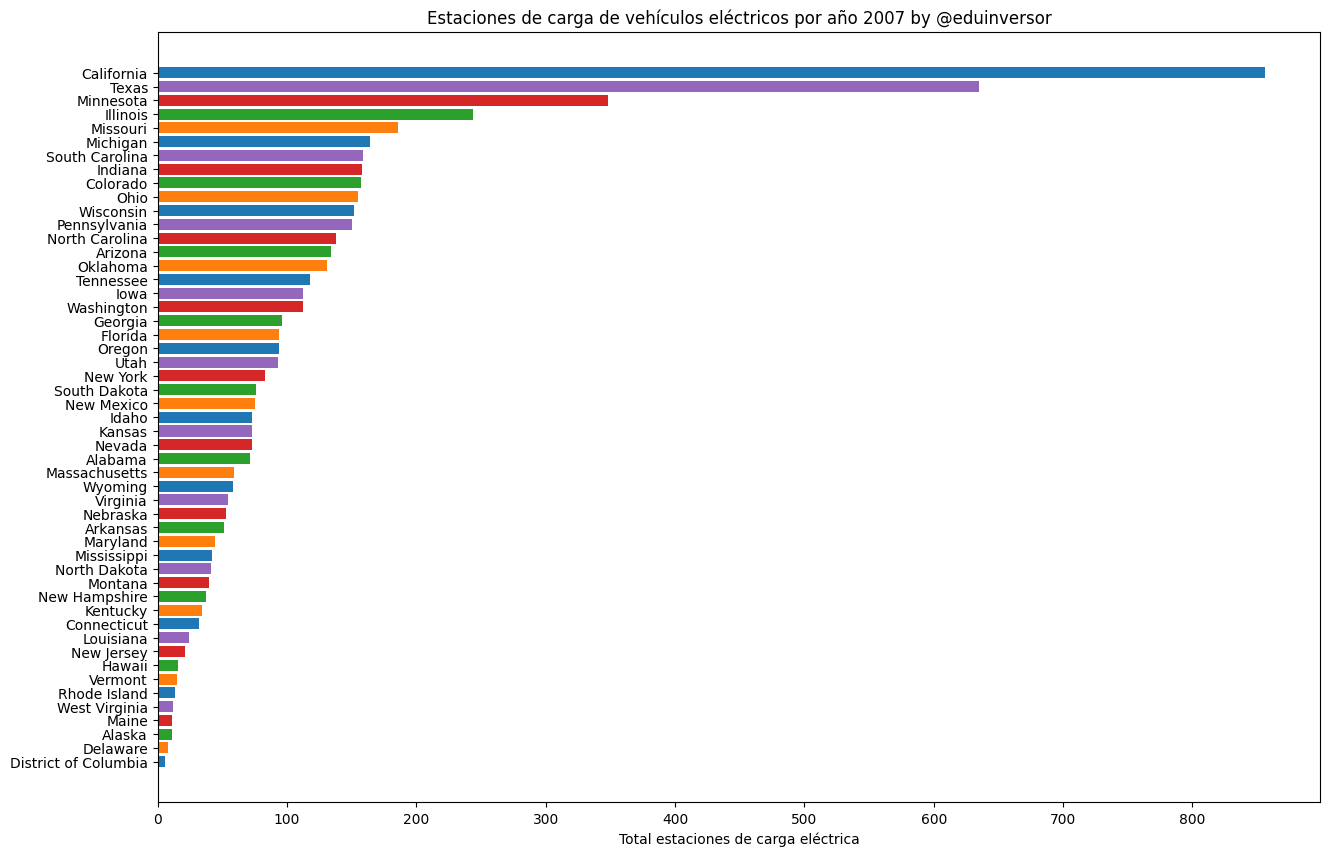

In [17]:
from matplotlib import animation

df_historico_grafico = df_historico[['Year', 'State', 'Total']]
df_historico_grafico.sort_values(by='Year', ascending=True, inplace=True)

states_plot = df_historico_grafico['State'].unique()

barchart_data  = df_historico_grafico.loc[df_historico_grafico['State'].isin(states_plot), :]

font = {
    'weight': 'normal',
    'size'  :  40,
    'color': 'lightgray'
}

years = barchart_data['Year'].unique()
colors =['#FF0000','#169b62','#008c45','#aa151b','#002868']

fig, ax = plt.subplots(figsize=(15, 10))

label = ax.text(0.95, 0.2, years[0],
                horizontalalignment = 'right',
                verticalalignment = 'top',
                transform = ax.transAxes,
                fontdict = font)

# Obtener una paleta de colores de seaborn con al menos 50 colores distintos
palette = sns.color_palette("tab10", n_colors=5)


def update_barchart(i):
  year = years[i]
  data_temp = barchart_data.loc[barchart_data['Year'] == year, :]
  data_temp.sort_values(by='Total', ascending=True, inplace=True)
  ax.clear()
  ax.barh(data_temp.State, data_temp.Total,  color = palette )
  label.set_text(year)
  ax.set_xlabel("Total estaciones de carga eléctrica")
  ax.set_title("Estaciones de carga de vehículos eléctricos por año " + str(year) + ' by @eduinversor')


animacion = animation.FuncAnimation(fig, update_barchart, frames = len(years),interval = 550)
animacion.save('barchart.gif')

In [18]:
from IPython.display import HTML
HTML(animacion.to_html5_video())

In [ ]:
df_2023 = df_historico.loc[df_historico['Year'] == 2023, ['State', 'Electric_stations']]
df_2023



---



In [20]:
df_historico['State'].unique()

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'], dtype=object)

## Stations

In [21]:
df_stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70406 entries, 0 to 70405
Data columns (total 65 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Fuel Type Code                    70406 non-null  object 
 1   Station Name                      70406 non-null  object 
 2   Street Address                    70405 non-null  object 
 3   Intersection Directions           4492 non-null   object 
 4   City                              70406 non-null  object 
 5   State                             70406 non-null  object 
 6   ZIP                               70405 non-null  object 
 7   Plus4                             0 non-null      float64
 8   Station Phone                     65204 non-null  object 
 9   Status Code                       70406 non-null  object 
 10  Expected Date                     1218 non-null   object 
 11  Groups With Access Code           70406 non-null  object 
 12  Acce

In [22]:
df_stations.head(5)

,Fuel Type Code,Station Name,Street Address,Intersection Directions,City,State,ZIP,Plus4,Station Phone,Status Code,...,EV Pricing (French),LPG Nozzle Types,Hydrogen Pressures,Hydrogen Standards,CNG Fill Type Code,CNG PSI,CNG Vehicle Class,LNG Vehicle Class,EV On-Site Renewable Source,Restricted Access
0,CNG,Spire - Montgomery Operations Center,2951 Chestnut St,NaN,Montgomery,AL,36107,NaN,NaN,E,...,NaN,NaN,NaN,NaN,B,3600,MD,NaN,NaN,NaN
1,CNG,PS Energy - Atlanta,340 Whitehall St,"From I-7585 N, exit 91 to Central Ave, left on...",Atlanta,GA,30303,NaN,770-350-3000,E,...,NaN,NaN,NaN,NaN,Q,3600,MD,NaN,NaN,False
2,CNG,Metropolitan Atlanta Rapid Transit Authority,2424 Piedmont Rd NE,NaN,Atlanta,GA,30324,NaN,NaN,E,...,NaN,NaN,NaN,NaN,Q,3000,LD,NaN,NaN,NaN
3,CNG,United Parcel Service,270 Marvin Miller Dr,NaN,Atlanta,GA,30336,NaN,NaN,E,...,NaN,NaN,NaN,NaN,B,3600,HD,NaN,NaN,NaN
4,CNG,Arkansas Oklahoma Gas Corp,2100 S Waldron Rd,NaN,Fort Smith,AR,72903,NaN,479-783-3188,E,...,NaN,NaN,NaN,NaN,Q,3600,MD,NaN,NaN,False


In [23]:
analizar_dataframe(df_stations, 90)

,Tipo de dato,Total No Nulos,Total Nulos,% Nulos,Borrar?,Total Ceros,Columna con Espacios,count,mean,std,min,25%,50%,75%,max
Fuel Type Code,object,70406,0,0.000000,,0,True,nan,nan,nan,nan,nan,nan,nan,nan
Station Name,object,70406,0,0.000000,,0,True,nan,nan,nan,nan,nan,nan,nan,nan
Street Address,object,70405,1,0.000000,,0,True,nan,nan,nan,nan,nan,nan,nan,nan
Intersection Directions,object,4492,65914,93.620000,BORRAR,0,True,nan,nan,nan,nan,nan,nan,nan,nan
City,object,70406,0,0.000000,,0,False,nan,nan,nan,nan,nan,nan,nan,nan
State,object,70406,0,0.000000,,0,False,nan,nan,nan,nan,nan,nan,nan,nan
ZIP,object,70405,1,0.000000,,0,False,nan,nan,nan,nan,nan,nan,nan,nan
Plus4,float64,0,70406,100.000000,BORRAR,0,False,0.000000,nan,nan,nan,nan,nan,nan,nan
Station Phone,object,65204,5202,7.390000,,0,True,nan,nan,nan,nan,nan,nan,nan,nan
Status Code,object,70406,0,0.000000,,0,True,nan,nan,nan,nan,nan,nan,nan,nan


In [24]:
df_stations.isna().sum().sort_values(ascending=False)

Plus4                           70406
BD Blends (French)              70404
EV Other Info                   70357
LNG On-Site Renewable Source    70344
Hydrogen Status Link            70323
                                ...  
ID                                  0
Updated At                          0
Station Name                        0
Country                             0
Fuel Type Code                      0
Length: 65, dtype: int64

In [25]:
df_stations['LNG Vehicle Class'].unique()

array([nan, 'HD'], dtype=object)

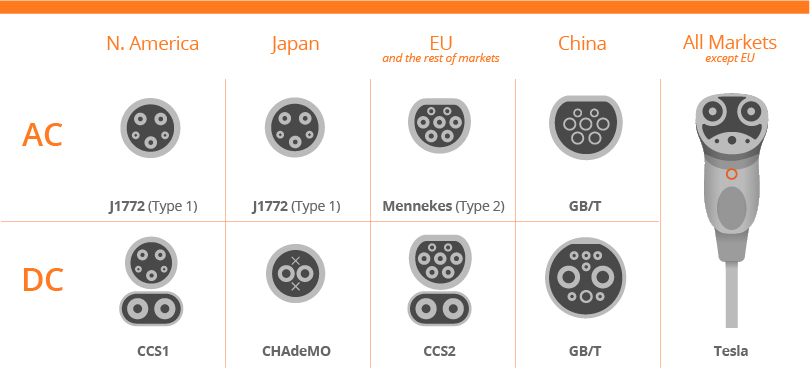

In [26]:
ev_connector_types = ["J1772",
                      "CHADEMO",
                      "COMBO",
                      "NEMA515",
                      "NEMA520",
                      "NEMA1450",
                      "TESLA"
                      ""
                      ]

In [27]:
# Completa los valores NaN con el valor 'unknown'
df_stations['EV Connector Types'].fillna('unknown', inplace=True)

In [28]:
df_stations['EV Connector Types'].value_counts()

EV Connector Types
J1772                               47190
unknown                              9716
CHADEMO J1772COMBO                   4357
TESLA                                3892
J1772 TESLA                          2834
CHADEMO J1772 J1772COMBO             1061
J1772COMBO                            519
CHADEMO J1772                         331
J1772 J1772COMBO                      134
J1772 NEMA515                         122
CHADEMO                               112
J1772 NEMA520                          95
J1772 NEMA1450                         23
CHADEMO J1772 J1772COMBO TESLA          6
CHADEMO J1772COMBO TESLA                2
CHADEMO J1772 NEMA520                   1
J1772COMBO TESLA                        1
J1772COMBO NEMA515                      1
CHADEMO J1772 J1772COMBO NEMA520        1
NEMA1450 TESLA                          1
CHADEMO NEMA520                         1
J1772 NEMA515 NEMA520                   1
J1772COMBO NEMA520                      1
CHADEMO J1772CO

In [29]:
df_stations['EV Connector Types'] = df_stations['EV Connector Types'].replace('J1772 J1772COMBO', 'J1772 COMBO')

In [30]:
mask = df_stations['EV Connector Types'].str.contains('CHADEMO')
df_stations[mask]


,Fuel Type Code,Station Name,Street Address,Intersection Directions,City,State,ZIP,Plus4,Station Phone,Status Code,...,EV Pricing (French),LPG Nozzle Types,Hydrogen Pressures,Hydrogen Standards,CNG Fill Type Code,CNG PSI,CNG Vehicle Class,LNG Vehicle Class,EV On-Site Renewable Source,Restricted Access
156,ELEC,LADWP - Truesdale Center,11797 Truesdale St,NaN,Sun Valley,CA,91352,NaN,NaN,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
159,ELEC,LADWP - John Ferraro Building,111 N Hope St,Across Hope,Los Angeles,CA,90012,NaN,NaN,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
160,ELEC,LADWP - Haynes Power Plant,6801 E 2nd St,NaN,Long Beach,CA,90803,NaN,NaN,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
163,ELEC,LADWP - EV Service Center,1630 N Main St,NaN,Los Angeles,CA,90012,NaN,NaN,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1588,ELEC,LADWP - Valley Center Admin Lot,14401 Saticoy St,At Van Nuys Blvd,Van Nuys,CA,91405,NaN,NaN,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70236,ELEC,ECG MSC DC 1,3299 Cooley Mesa Rd,NaN,Gypsum,CO,81637,NaN,888-758-4389,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70275,ELEC,SNOPUD POWERED MUEVE3105 #2,2320 California St,NaN,Everett,WA,98201,NaN,888-758-4389,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70276,ELEC,SNOPUD POWERED MUEVE3105 #1,2320 California St,NaN,Everett,WA,98201,NaN,888-758-4389,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70395,ELEC,EVolveNY Salamanca,768 Broad Street,NaN,Salamanca,NY,14779,NaN,855-900-7584,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
df_stations['EV Connector Types'].unique()

array(['unknown', 'CHADEMO J1772 J1772COMBO', 'J1772', 'CHADEMO J1772',
       'J1772 NEMA520', 'J1772 NEMA515', 'J1772 TESLA',
       'CHADEMO J1772 NEMA515', 'J1772 COMBO', 'J1772 NEMA1450', 'TESLA',
       'CHADEMO', 'CHADEMO J1772 NEMA520 TESLA', 'CHADEMO J1772COMBO',
       'CHADEMO J1772 J1772COMBO TESLA', 'J1772COMBO',
       'CHADEMO J1772COMBO NEMA520', 'CHADEMO NEMA520',
       'J1772COMBO NEMA520', 'J1772 NEMA515 NEMA520',
       'CHADEMO J1772 NEMA520', 'NEMA1450 TESLA',
       'CHADEMO J1772 J1772COMBO NEMA520', 'CHADEMO J1772COMBO TESLA',
       'J1772COMBO NEMA515', 'J1772COMBO TESLA', 'NEMA1450'], dtype=object)

In [32]:
df_stations['EV Other Info'].unique()

array([nan, '1 SP Inductive', '3 SP Inductive', '2 Tesla Conductive',
       '1 Tesla Conductive', '1 Conductive 120V', '7 Conductive 120V',
       '1 LP Inductive', 'DCFC', 'L2'], dtype=object)

In [33]:
df_stations['EV Pricing'].unique()

array([nan, 'Free', 'Pay to Park', 'Free; parking fee',
       '$2 service fee; $0.45 per kWh', '$12 parking fee',
       '$7 per session', 'Free; parking is $8 per day.',
       '$0.30 per kWh; $0.45 per kWh from 4pm-9pm',
       '$1 per hour for first two hours; $3 per hour thereafter',
       'Free; $6.00 for parking day pass for non-permit holders',
       '$20 parking fee', '$9 parking fee',
       "Pay for garage' charging is free", '$1.50/hr', '$2 parking fee',
       '$0.75 per hour parking fee',
       '$1 per first and second half-hour parking fee; $1 per each additional hour parking fee',
       'Free; metered parking', 'Free; meter charge', '$10 per session',
       'Free for guests; $10 for non-guests',
       '$5 per session, customers pay up to $20 for leaving car connected after done charging',
       '$6 per session', '$1 per hour', '$0.25 per hour parking fee',
       '$1.50 per hour', 'Variable fee', '$0.13 per kWh',
       '$1 per hour parking fee; Maximum session t

In [34]:
df_stations['EV On-Site Renewable Source'].unique()

array([nan, 'SOLAR', 'WIND', 'HYDRO', 'NONE', 'WASTEWATER', 'LANDFILL'],
      dtype=object)

In [35]:
df_stations['BD Blends (French)'].unique()

array([nan, 'B100', 'B100, B50, B20'], dtype=object)

In [36]:
df_stations['Intersection Directions (French)'].unique()

array([nan, "A coté de l'office d'automobile",
       "A l'arrière du batiment avec une entrée très atroite",
       'SituÃ©e sur le cÃ´tÃ© ouest du parc',
       'Quai de chargement 2 -En arrière du batiment',
       "20 km à\xa0 l'ouest de Grand Falls-Windsor",
       "Située\xa0a l'intersection du stationnement, ou les bornes de recharge pour les VR se situent",
       'SituÃ©e sur le cÃ´tÃ© du bÃ¢timent dans la ruelle',
       'Coin arrière du bâtiment',
       'Stationnement principal - Coin sud-est du bâtiment',
       'SituÃ©e dans un nouveau projet sur la promenade Shepard, Ã©loignÃ© de tout bÃ¢timent. La promenade Shepard est Ã\xa0 votre droite lorsque que vous venez de la Trans Canada.',
       'Situé a la cité des enseignes communautaires près de la route dans un stationnement de cour de triage',
       "Par l'entrée principale", 'Sur la route 19A',
       'Entre la promenade Riverglen et la promenade Riveredge',
       "deux unitÃ©s Ã\xa0Â\xa0 l'extÃ©rieur, une unitÃ© Ã\xa0

## Feature Reduction

In [37]:
try:
  df_stations.drop(["Plus4",
                    "LNG Vehicle Class",
                    "Intersection Directions (French)",
                    "Access Days Time (French)",
                    "Groups With Access Code (French)",
                    "LNG On-Site Renewable Source",
                    "EV Level1 EVSE Num",
                    "EV Other Info",
                    "Hydrogen Status Link",
                    "BD Blends (French)",
                    "Hydrogen Is Retail",
                    "CNG Storage Capacity",
                    "Hydrogen Pressures",
                    "Hydrogen Standards",
                    "EV On-Site Renewable Source"
                    ], axis=1, inplace=True)
  print("Se eliminaron las características solicitadas.")
except Exception as e:
    print("La característica no existe. ", e)

Se eliminaron las características solicitadas.


In [38]:
try:
  df_stations.drop(["EV DC Fast Count",
                    "Access Detail Code",
                    "E85 Blender Pump",
                    "Intersection Directions",
                    "EV Pricing (French)",
                    "LPG Primary",
                    "LPG Nozzle Types",
                    "NG Vehicle Class",
                    "CNG Vehicle Class",
                    "NG Fill Type Code",
                    "CNG Fill Type Code",
                    "CNG PSI",
                    "NG PSI",
                    "E85 Other Ethanol Blends",
                    "Expected Date",
                    "BD Blends",
                    "CNG Dispenser Num",
                    "Federal Agency Code",
                    "Federal Agency ID",
                    "Federal Agency Name",
                    "CNG On-Site Renewable Source",
                    "CNG Total Compression Capacity",
                    ], axis=1, inplace=True)
  print("Se eliminaron las características solicitadas.")
except Exception as e:
    print("La característica no existe. ", e)

Se eliminaron las características solicitadas.


In [39]:
try:
  df_stations.drop(["ID"
                    ], axis=1, inplace=True)
  print("Se eliminaron las características solicitadas.")
except Exception as e:
    print("La característica no existe. ", e)

Se eliminaron las características solicitadas.
